In [253]:
%pip install z3-solver
%pip install numpy
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [254]:
from z3 import *
import numpy as np
import matplotlib.pyplot as plt
s = Solver()

In [255]:
# Constants
chip_size = (30, 30)
component_sizes =  [[4,5],
                    [4,6],
                    [5,20],
                    [6,9],
                    [6,10],
                    [6,11],
                    [7,8],
                    [7,12],
                    [10,10],
                    [10,20]]
power_component_size = (4,3)
min_distance_power_components = 16

In [256]:
# Init variables respresenting start x and y of the power components and their orientation
power0_x = Int("power0_x")
power0_y = Int("power0_y")
power0_is_vertical = Bool("power0_is_vertical")

power1_x = Int("power1_x")
power1_y = Int("power1_y")
power1_is_vertical = Bool("power1_is_vertical")

In [257]:
# Init variables for every other component
xyb = []
for idx, size in enumerate(component_sizes):
    comp_x = Int(f"comp{idx}_x")
    comp_y = Int(f"comp{idx}_y")
    comp_is_vertical = Bool(f"comp{idx}_is_vertical")
    xyb.append((comp_x, comp_y, comp_is_vertical))

In [258]:
# Add positivity constraints
s.add(power0_x >= 0, power0_y >= 0)
s.add(power1_x >= 0, power1_y >= 0)
for comp_x, comp_y, _ in xyb:
    s.add(comp_x >= 0, comp_y >= 0)

In [259]:
# Make sure components fit withing chip boundaries
s.add(
    If
    (
        power0_is_vertical, 
        And
        (
            power0_x + power_component_size[0] < chip_size[0], 
            power0_y + power_component_size[1] < chip_size[1]
        ),
        And
        (
            power0_x + power_component_size[1] < chip_size[0], 
            power0_y + power_component_size[0] < chip_size[1]
        )
    )
)

s.add(
    If
    (
        power1_is_vertical, 
        And
        (
            power1_x + power_component_size[0] < chip_size[0], 
            power1_y + power_component_size[1] < chip_size[1]
        ),
        And
        (
            power1_x + power_component_size[1] < chip_size[0], 
            power1_y + power_component_size[0] < chip_size[1]
        )
    )
)
for idx, packed_values in enumerate(xyb):
    comp_x, comp_y, comp_is_vertical = packed_values
    s.add(
        If
        (
            comp_is_vertical, 
            And
            (
                comp_x + component_sizes[idx][0] < chip_size[0], 
                comp_y + component_sizes[idx][1] < chip_size[1]
            ),
            And
            (
                comp_x + component_sizes[idx][1] < chip_size[0], 
                comp_y + component_sizes[idx][0] < chip_size[1]
            )
        )
    )

In [260]:
# Adding constraints s.t. no component overlays another
# byetween the power components
s.add(
    Or
    (
        power1_x + If(power1_is_vertical, power_component_size[0], power_component_size[1]) <= power0_x,
        power0_x + If(power0_is_vertical, power_component_size[0], power_component_size[1]) <= power1_x,
        power1_y + If(power1_is_vertical, power_component_size[1], power_component_size[0]) <= power0_y,
        power0_y + If(power0_is_vertical, power_component_size[1], power_component_size[0]) <= power1_y
    )
)

for idx, (comp_x, comp_y, comp_is_vertical) in enumerate(xyb):
    # between power and regular components
    s.add(
        Or
        (
            comp_x + If(comp_is_vertical, component_sizes[idx][0], component_sizes[idx][1]) <= power0_x,
            power0_x + If(power0_is_vertical, power_component_size[0], power_component_size[1]) <= comp_x,
            comp_y + If(comp_is_vertical, component_sizes[idx][1], component_sizes[idx][0]) <= power0_y,
            power0_y + If(power0_is_vertical, power_component_size[1], power_component_size[0]) <= comp_y
        )
    )
    s.add(
        Or
        (
            comp_x + If(comp_is_vertical, component_sizes[idx][0], component_sizes[idx][1]) <= power1_x,
            power1_x + If(power1_is_vertical, power_component_size[0], power_component_size[1]) <= comp_x,
            comp_y + If(comp_is_vertical, component_sizes[idx][1], component_sizes[idx][0]) <= power1_y,
            power1_y + If(power1_is_vertical, power_component_size[1], power_component_size[0]) <= comp_y
        )
    )
    
    # inbetween regular components
    for idx2, (comp2_x, comp2_y, comp2_is_vertical) in enumerate(xyb[idx+1:], start=idx+1):
        s.add(
            Or
            (
                comp_x + If(comp_is_vertical, component_sizes[idx][0], component_sizes[idx][1]) <= comp2_x,
                comp2_x + If(comp2_is_vertical, component_sizes[idx2][0], component_sizes[idx2][1]) <= comp_x,
                comp_y + If(comp_is_vertical, component_sizes[idx][1], component_sizes[idx][0]) <= comp2_y,
                comp2_y + If(comp2_is_vertical, component_sizes[idx2][1], component_sizes[idx2][0]) <= comp_y
            )
        )


In [261]:
# Adding constraints s.t. every component is adjacent to a power component.

# Overlap in one axis
def is_overlapping(pos1, size1, pos2, size2):
    return And(
        pos1 < pos2 + size2,
        pos2 < pos1 + size1
    )

# Checks if one axis is overlapping and if so, checks whether the other axis is neighboring
def is_adjacent(comp_x, comp_y, comp_width, comp_height, comp2_x, comp2_y, comp2_width, comp2_height):
    is_horizontally_overlapping = is_overlapping(comp_x, comp_width, comp2_x, comp2_width)
    is_horizontally_adjacent = And(
        is_horizontally_overlapping,
        Or(
            comp2_y + comp2_height == comp_y,
            comp_y + comp_height == comp2_y
        )
    )

    is_vertically_overlapping = is_overlapping(comp_y, comp_height, comp2_y, comp2_height)
    is_vertically_adjacent = And(
        is_vertically_overlapping,
        Or(
            comp2_x + comp2_width == comp_x,
            comp_x + comp_width == comp2_x
        )
    )

    return Or(is_horizontally_adjacent, is_vertically_adjacent)


for idx, (comp_x, comp_y, comp_is_vertical) in enumerate(xyb):
    comp_width = If(comp_is_vertical, component_sizes[idx][0], component_sizes[idx][1])
    comp_height = If(comp_is_vertical, component_sizes[idx][1], component_sizes[idx][0])
    power0_width = If(power0_is_vertical, power_component_size[0], power_component_size[1])
    power0_height = If(power0_is_vertical, power_component_size[1], power_component_size[0])
    power1_width = If(power1_is_vertical, power_component_size[0], power_component_size[1])
    power1_height = If(power1_is_vertical, power_component_size[1], power_component_size[0])
    s.add(
        Or(
            is_adjacent(comp_x, comp_y, comp_width, comp_height, power0_x, power0_y, power0_width, power0_height),
            is_adjacent(comp_x, comp_y, comp_width, comp_height, power1_x, power1_y, power1_width, power1_height)
        )
    )

In [ ]:
# Adding constraints s.t. the power components are min_distance_power_components apart
power0_width = If(power0_is_vertical, power_component_size[0], power_component_size[1])
power0_height = If(power0_is_vertical, power_component_size[1], power_component_size[0])
power1_width = If(power1_is_vertical, power_component_size[0], power_component_size[1])
power1_height = If(power1_is_vertical, power_component_size[1], power_component_size[0])

power0_center_x = (power0_x + power0_width / 2) - 0.5
power0_center_y = (power0_y + power0_height / 2) - 0.5
power1_center_x = (power1_x + power1_width / 2) - 0.5
power1_center_y = (power1_y + power1_height / 2) - 0.5

s.add(
    Or
    (
        power0_center_x + power1_center_x > min_distance_power_components,
        power1_center_x + power0_center_x > min_distance_power_components,
        power0_center_y + power1_center_y > min_distance_power_components,
        power1_center_y + power0_center_y > min_distance_power_components,
    ))

In [263]:
s.check()

sat

In [264]:
model = s.model()

# Visualizing the result

In [266]:
cmap = plt.get_cmap("Set3", 12)

labels = {
    0: "Unassigned",
    1: "Component 1",
    2: "Component 2",
    3: "Component 3",
    4: "Component 4",
    5: "Component 5",
    6: "Component 6",
    7: "Component 7",
    8: "Component 8",
    9: "Component 9",
    10: "Component 10",
    11: "Power Component"
}

def map_key2scale(key):
    return (key+0.5) * 11/12


In [267]:
def translate_model_to_image(model):
    image_grid = np.zeros(chip_size)
    # color in the power components
    x = model[power0_x].as_long()
    y = model[power0_y].as_long()

    if model[power0_is_vertical]:
        image_grid[x : x + power_component_size[0], y : y + power_component_size[1]] = 11
    else:
        image_grid[x : x + power_component_size[1], y : y + power_component_size[0]] = 11
    x = model[power1_x].as_long()
    y = model[power1_y].as_long()
    if model[power1_is_vertical]:
        image_grid[x : x + power_component_size[0], y : y + power_component_size[1]] = 11
    else:
        image_grid[x : x + power_component_size[1], y : y + power_component_size[0]] = 11
    # color in the rest of the components
    for idx, (comp_x, comp_y, comp_is_vertical) in enumerate(xyb):
        x = model[comp_x].as_long()
        y = model[comp_y].as_long()

        if model[comp_is_vertical]:
            image_grid[x : x + component_sizes[idx][0], y : y + component_sizes[idx][1]] = idx + 1
        else:
            image_grid[x : x + component_sizes[idx][1], y : y + component_sizes[idx][0]] = idx + 1
    return image_grid

In [268]:
translate_model_to_image(model)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  0.],
       [ 0.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  0.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  0.],
       [ 0.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  0.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  0.],
       [ 0.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  0.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  0.],
       [ 0.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  0.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  0.],
       [ 0.,  7.,  7.,  7.,  7.,  7.,  7.,  7., 11., 11., 11.,  1.,  1.,
         1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,

In [269]:
def visualize_result(model):
    image_grid = translate_model_to_image(model).T
    #np.array([
        #[int(model[element].as_long()) for element in row]
        #for row in x
    #])
    #image_grid = np.random.randint(0,11,[30,30])
    #print(image_grid[0])
    fig, ax = plt.subplots()
    im = ax.imshow(image_grid, cmap="Paired", interpolation="nearest", origin="upper", aspect="equal")
    ax.set_xticks(np.arange(-0.5, 30, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 30, 1), minor=True)
    ax.grid(which="minor", color="black", linewidth=1)

    cbar = fig.colorbar(im, ax=ax, ticks=[map_key2scale(key) for key in labels.keys()])
    cbar.ax.set_yticklabels(list(labels.values()))
    plt.show() 

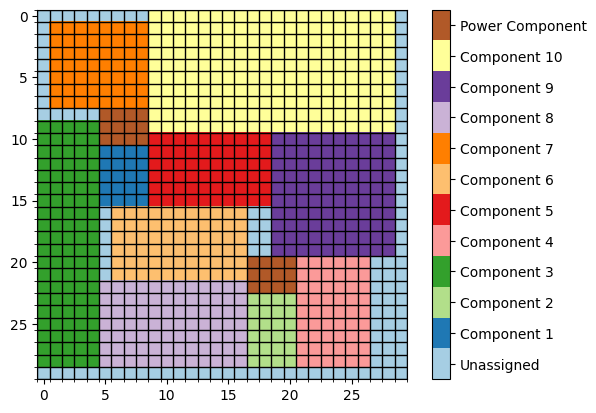

In [270]:
visualize_result(model)

In [271]:
for idx, (comp_x, comp_y, comp_is_vertical) in enumerate(xyb):
    print(idx+1, model[comp_is_vertical])

1 True
2 True
3 True
4 True
5 False
6 False
7 False
8 False
9 None
10 False
